<a href="https://colab.research.google.com/github/jamespan1118/Xenopus_signal_processing/blob/main/Noise_Filtering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Objective: Filter out non-white noise in female and male recording segments

In [65]:
#importing libraries and packages
import librosa
from librosa import display
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.io.wavfile import write
import numpy as np
import scipy
from scipy.fft import fft, fftfreq, rfft, rfftfreq, irfft
import random
from scipy.io import wavfile
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###Code for separation

In [19]:
def clear_out(lower,upper,data,points_per_freq):
  target_idx_noise_lower = int(points_per_freq * lower)
  target_idx_noise_upper = int(points_per_freq * upper)
  data[: target_idx_noise_lower] = 0
  data[target_idx_noise_upper:] = 0
  
def fourier_transform(samples, sampling_rate):
  #fourier transform on audio file
  yf = rfft(samples)
  xf = rfftfreq(len(samples), 1 / sampling_rate)
  return xf,yf

#smooth the curve
def smooth_curve(randomlist_yf,sigma=40):
  #We get a smoother curve upon increasing the value of sigma.
  y_smoothed = gaussian_filter1d(randomlist_yf, sigma)
  peaks, _  = scipy.signal.find_peaks(y_smoothed)
  troughs, _  = scipy.signal.find_peaks(-y_smoothed)
  return peaks,troughs,y_smoothed

def peak_processing(peaks,randomlist_xf):
  #remove all peaks with xf value below 450, between 700 and 1600, and above 2500
  for i in peaks:
    if((randomlist_xf[i]<450) or
      #((randomlist_xf[i]>700) and (randomlist_xf[i]<1600))or
      (randomlist_xf[i]>2500)):
      peaks = np.delete(peaks,np.argwhere(peaks == i))
  peaks_list = randomlist_xf[peaks]
  return peaks_list

def trough_processing(troughs,randomlist_xf):
  #if the smallest trough that's below 450 is below 350  replace it with 350
  if(randomlist_xf[troughs].min()<350):
    troughs_list = np.where(randomlist_xf[troughs]<350,350,randomlist_xf[troughs])
  else:
    troughs_list = np.append([350], randomlist_xf[troughs], axis = 0)
  return troughs_list

def generate_boundaries(peaks_list,troughs_list):
  #getting the boundaries for the female call
  i = 0
  while(troughs_list[i] < peaks_list[0]):
    i+=1
  upper_bound_0 = troughs_list[i]
  lower_bound_0 = troughs_list[i-1]

  #getting the boundaries for the male call
  while(troughs_list[i] < peaks_list[1]):
    i+=1
  upper_bound_1 = troughs_list[i]
  #the lower bound of the male call: take the 
  #difference between the upper bound and the peak,
  #and use the peak value to subtract the difference
  difference = upper_bound_1 - peaks_list[1]
  lower_bound_1 = peaks_list[1] - difference
  #the lower bound of male call can't go below 1500Hz for
  #Xenopus Laevis or Xenopus Petersii
  if(lower_bound_1 < 1500):
    lower_bound_1 = 1500
  boundary_list = [150,lower_bound_0,upper_bound_0,lower_bound_1,3000]
  return boundary_list

def get_audio(samples,lowerlimit,upperlimit,points_per_freq):
  yf_special = rfft(samples)
  clear_out(lowerlimit,upperlimit,yf_special,points_per_freq)
  new_sig = irfft(yf_special)
  return new_sig

In [73]:
def male_female_call_separation(file_path,sampling_rate=44100):
  #load audio file
  samples, sampling_rate = librosa.load(file_path,sr=sampling_rate)

  #perform fourier transform on the data
  xf,yf = fourier_transform(samples, sampling_rate)

  #get the number of points per frequency
  points_per_freq = len(xf) / (sampling_rate / 2)

  #rough clean of data for smoothing
  clear_out(150,3000,yf,points_per_freq)

  #sample down audio file to 23274 data points
  randomlist = random.sample(list(range(0,(len(xf)-1))),23274)
  randomlist.sort()
  randomlist_xf = xf[randomlist]
  randomlist_yf = np.abs(yf)[randomlist]

  peaks,troughs,y_smoothed = smooth_curve(randomlist_yf)

  #data processing on the peaks and troughs
  peaks_list = peak_processing(peaks,randomlist_xf)
  troughs_list = trough_processing(troughs,randomlist_xf)

  boundary_list = generate_boundaries(peaks_list,troughs_list)

  #plot the graph
  '''
  plt.figure(figsize=(20,5))
  plt.plot(xf,np.abs(yf),color="grey")
  plt.plot(randomlist_xf,y_smoothed,color="red")
  plt.plot(randomlist_xf[peaks],y_smoothed[peaks],"x")
  plt.plot(randomlist_xf[troughs],y_smoothed[troughs],"o",color="green")
  plt.vlines(boundary_list,-10,3000,colors='black', linestyles='dashed')
  ticks = np.concatenate([np.arange(0, 4000, step=1000),boundary_list])
  ticks.sort()
  plt.xticks(ticks)
  plt.xlim((0,4000))
  plt.show()
  '''
  noise = get_audio(samples,boundary_list[0],350,points_per_freq)
  female_and_noise = get_audio(samples,boundary_list[1],boundary_list[2],points_per_freq)
  male_and_noise = get_audio(samples,boundary_list[3],boundary_list[4],points_per_freq)

  return noise, female_and_noise, male_and_noise

##Step 1: Visualizing the waveplots

Before implementing processing procedures, we visualize waveplots of 
1. Noise
2. Noise+Male
3. Noise+Female 

so that we can intuitively understand the data

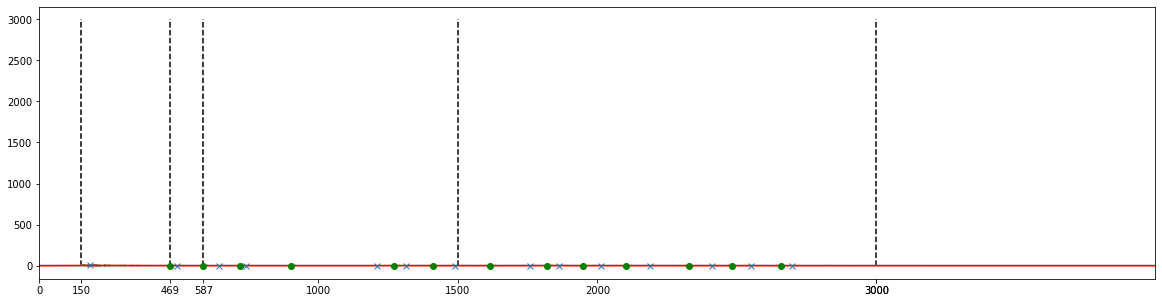

In [47]:
noise, female_and_noise, male_and_noise = male_female_call_separation('/content/drive/MyDrive/Xenopus_male_female_data/overall_copy/laevis/F832F-F837D/duets/segmented/rapping/02-F832F-F837D-220615_1835_1_21_614_624.wav')

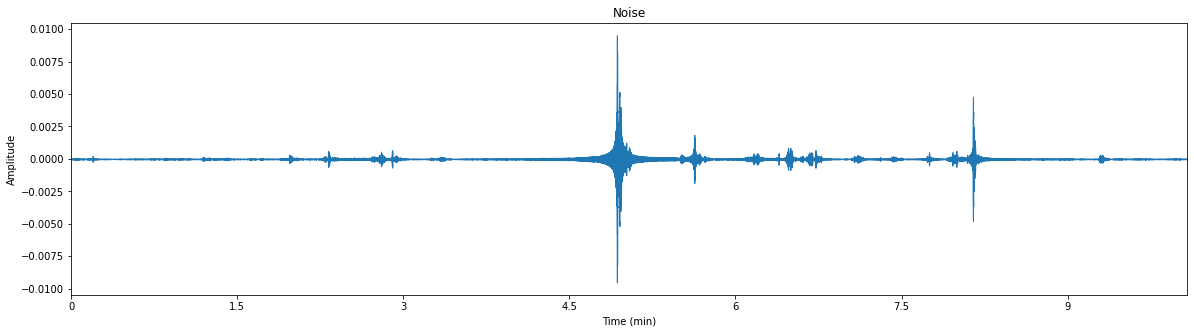

In [48]:
#plotting the audio data in time domain
sampling_rate = 44100
plt.figure(figsize=(20,5))
librosa.display.waveplot(y=noise,sr=sampling_rate)
plt.title("Noise")
plt.xlabel("Time (min)")
plt.ylabel("Amplitude")
plt.show()

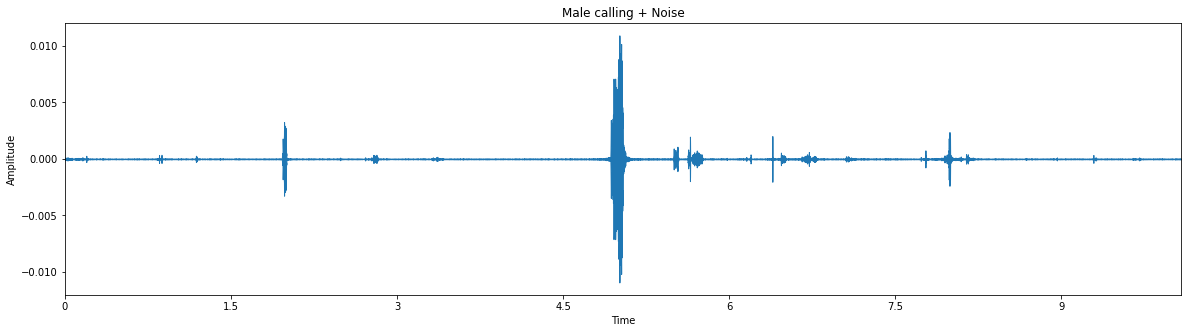

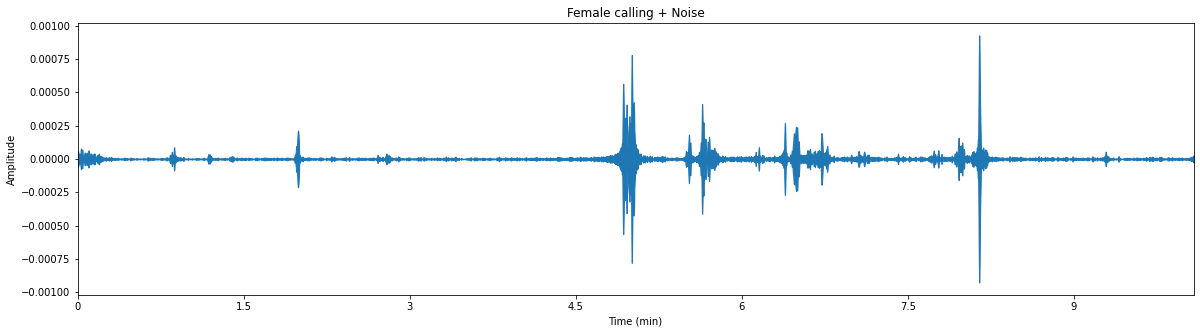

In [49]:
#plotting the waveplot of female and male for visual comparison
plt.figure(figsize=(20,5))
librosa.display.waveplot(y=male_and_noise,sr=sampling_rate)
plt.title('Male calling + Noise')
plt.ylabel("Amplitude")
plt.show()

plt.figure(figsize=(20,5))
librosa.display.waveplot(y=female_and_noise,sr=sampling_rate)
plt.title('Female calling + Noise')
plt.xlabel("Time (min)")
plt.ylabel("Amplitude")
plt.show()

## Step 2: Identifying the peaks in the Noise plot

In [50]:
#smooth the function
noise_smoothed = gaussian_filter1d(abs(noise),100)

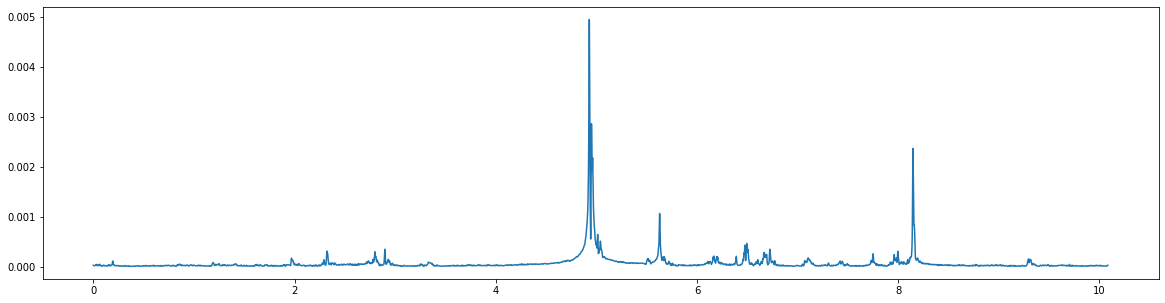

In [51]:
duration = len(noise)/sampling_rate
x_time = np.arange(0,duration,1/sampling_rate)
plt.figure(figsize=(20,5))
plt.plot(x_time,noise_smoothed)
#plt.xlim(180,200)
plt.show()

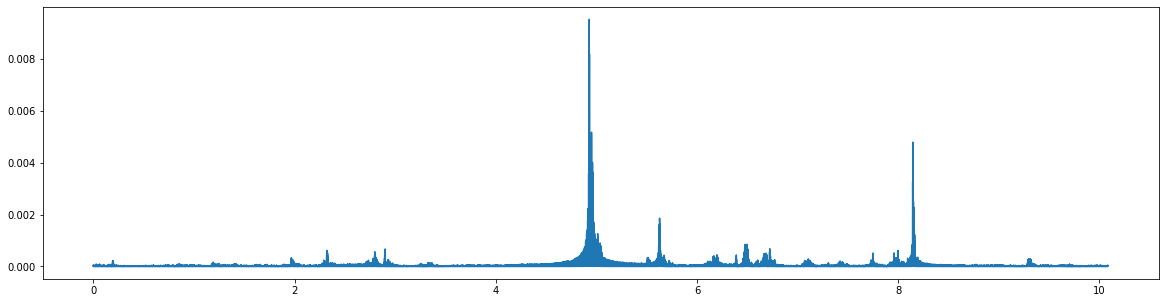

In [52]:
#compare against the original data
plt.figure(figsize=(20,5))
plt.plot(x_time,abs(noise))
#plt.xlim(180,200)
plt.show()

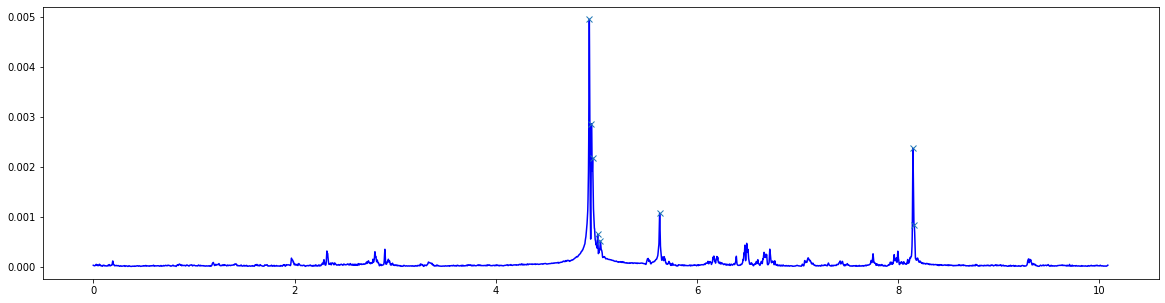

In [53]:
#identify peaks
noise_peaks, _ = scipy.signal.find_peaks(noise_smoothed, height=0.0005)
plt.figure(figsize=(20,5))
plt.plot(x_time,noise_smoothed,color = "blue")
plt.plot(x_time[noise_peaks],noise_smoothed[noise_peaks],'x')
plt.show()

In [54]:
noise_peaks

array([217398, 218354, 218845, 221063, 222258, 248228, 359247, 359795])

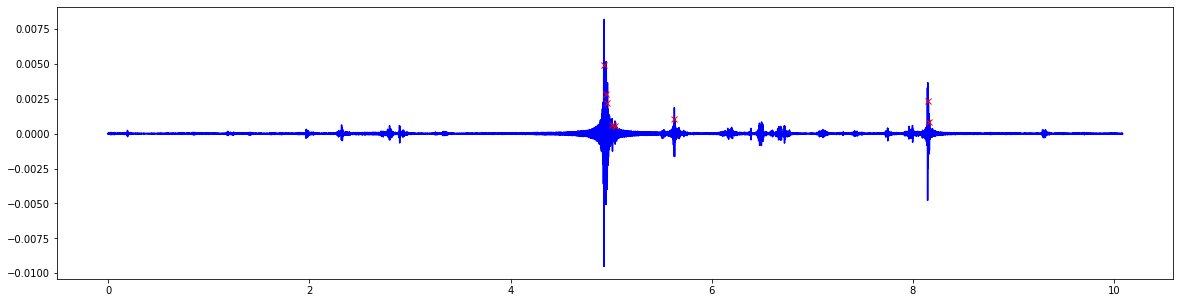

In [55]:
#female+noise sample with possible noise peak locations marked
plt.figure(figsize=(20,5))
plt.plot(x_time,noise,color = "blue")
plt.plot(x_time[noise_peaks],noise_smoothed[noise_peaks],'x',color='red')
#plt.xlim(375.5,375.75)
plt.show()

In [56]:
#remove +/-50 samples within the range of the peak 
#in female+noise and male+noise audio samples
for i in noise_peaks:
  female_and_noise[(i-1000):(i+1000)]=0

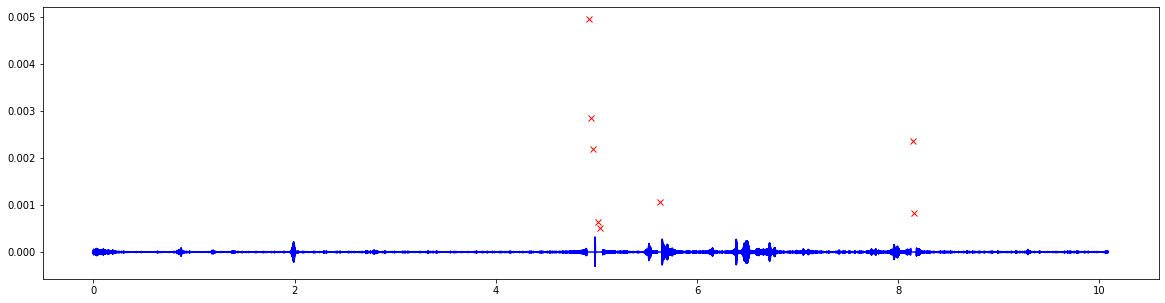

In [57]:
#female+noise sample with possible noise peak locations marked
plt.figure(figsize=(20,5))
plt.plot(x_time,female_and_noise,color = "blue")
plt.plot(x_time[noise_peaks],noise_smoothed[noise_peaks],'x',color='red')
#plt.xlim(430.43,430.7)
plt.show()

In [42]:
#write("/content/01-F818D-F8387-220616_0456_8min_selection (1)_female_filtered.wav",sampling_rate,samples_female)

In [ ]:
call_with_noise_samples, sampling_rate = librosa.load(call_with_noise_file,sr=44100)
noise_samples, sampling_rate = librosa.load(noise_file,sr=44100)

def noise_filter(noise_samples,call_with_noise_samples,sigma=100,sampling_rate=44100,peak_height=0.001):
  #get noise peaks
  noise_smoothed = gaussian_filter1d(abs(noise_samples),sigma)
  noise_peaks, _ = scipy.signal.find_peaks(noise_smoothed,height=peak_height)
  #filtering
  for i in noise_peaks:
    call_with_noise_samples[(i-sigma/2):(i+sigma/2)]=0
  return call_with_noise_samples

##Testing to see if noise filter works

####Separation prep functions

In [58]:
def noise_filter(noise_samples,call_with_noise_samples,sigma=100,remove_width=2000,sampling_rate=44100,peak_height=0.0005):
  #get noise peaks
  noise_smoothed = gaussian_filter1d(abs(noise_samples),sigma)
  noise_peaks, _ = scipy.signal.find_peaks(noise_smoothed,height=peak_height)
  #filtering
  for i in noise_peaks:
    call_with_noise_samples[int(i-remove_width/2):int(i+remove_width/2)]=0
  return call_with_noise_samples

####Actual testing

On a sample with all noise

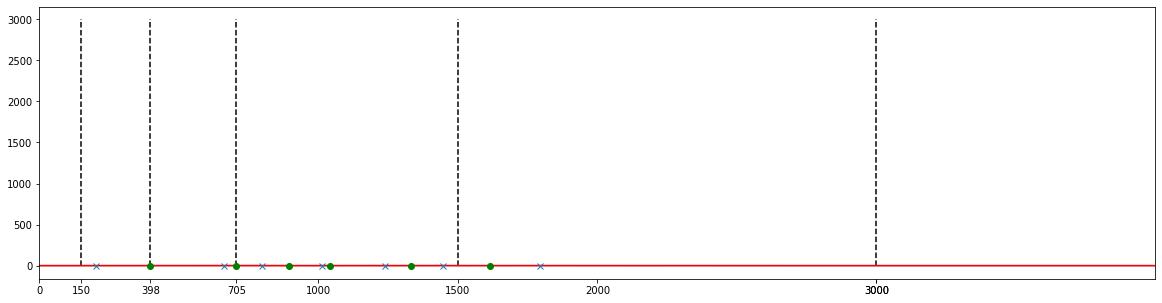

In [62]:
noise, female_and_noise, male_and_noise = male_female_call_separation('/content/drive/MyDrive/Xenopus_male_female_data/overall_copy/laevis/F818D-F8387/duets/segmented/rapping/01-F818D-F8387-220616_0252_2_41_3566_3594_male.wav')

In [63]:
female_signal_noise_filtered = noise_filter(noise,female_and_noise)

In [64]:
wavfile.write('/content/drive/MyDrive/random test/test_filter.wav',44100,female_signal_noise_filtered)

On all segmented duets in F818D-F8387

In [80]:
input_dir = '/content/drive/MyDrive/Xenopus_male_female_data/overall_copy/laevis/F818D-F8387/duets/segmented/rapping'
output_path_male = '/content/drive/MyDrive/Xenopus_male_female_data/overall_copy/laevis/F818D-F8387/separated_rapping/male'
output_path_female = '/content/drive/MyDrive/Xenopus_male_female_data/overall_copy/laevis/F818D-F8387/separated_rapping/female'
sr = 44100
for filename in os.listdir(input_dir):
  filepath = os.path.join(input_dir,filename)
  assert(os.path.exists(filepath))
  
  noise, female_and_noise, male_and_noise = male_female_call_separation(filepath)
  female_sig_noise_filtered = noise_filter(noise,female_and_noise)
  male_sig_noise_filtered = noise_filter(noise,male_and_noise)
  
  write_path_male = os.path.splitext(os.path.join(output_path_male,filename))[0]+'_male.wav'
  write_path_female = os.path.splitext(os.path.join(output_path_female,filename))[0]+'_female.wav'
  
  wavfile.write(write_path_male,sr,male_sig_noise_filtered)
  wavfile.write(write_path_female,sr,female_sig_noise_filtered)
  print(filename + " processed successfully")

01-F818D-F8387-220616_0252_2_29_3365_3370.wav processed successfully
01-F818D-F8387-220616_0252_2_30_3374_3383.wav processed successfully
01-F818D-F8387-220616_0252_2_31_3392_3404.wav processed successfully
01-F818D-F8387-220616_0252_2_32_3406_3432.wav processed successfully
01-F818D-F8387-220616_0252_2_33_3434_3445.wav processed successfully
01-F818D-F8387-220616_0252_2_34_3448_3464.wav processed successfully
01-F818D-F8387-220616_0252_2_35_3466_3504.wav processed successfully
01-F818D-F8387-220616_0252_2_36_3506_3516.wav processed successfully
01-F818D-F8387-220616_0252_2_37_3522_3533.wav processed successfully
01-F818D-F8387-220616_0252_2_38_3535_3544.wav processed successfully
01-F818D-F8387-220616_0252_2_39_3547_3563.wav processed successfully
01-F818D-F8387-220616_0252_2_40_3566_3594.wav processed successfully
01-F818D-F8387-220616_0252_3_1_16_26.wav processed successfully
01-F818D-F8387-220616_0252_3_2_33_41.wav processed successfully
01-F818D-F8387-220616_0252_3_3_49_55.wav pro

IndexError: ignored